# ユーザーデータに基づいた目標回数の生成

# 学習モデル

In [1]:
#ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

In [2]:
# データフレームとしてロード
df = pd.read_csv('userInfo.csv')

# 前処理

In [3]:
# Genderを数値に置換
df["Gender"][df["Gender"] == "Male"] = 1
df["Gender"][df["Gender"] == "Female"] = 2
df["Gender"][df["Gender"] == "Other"] = 3

# Frequencyを数値に置換
df["Frequency"][df["Frequency"] == "Low" ] = 1
df["Frequency"][df["Frequency"] == "Moderate" ] = 2
df["Frequency"][df["Frequency"] == "High" ] = 3

# Goalを数値に置換
df["Goal"][df["Goal"] == "MuscleStrength"] = 1
df["Goal"][df["Goal"] == "WeightLoss" ] = 2
df["Goal"][df["Goal"] == "HealthMaintenance" ] = 3

from sklearn.preprocessing import MinMaxScaler
# 正規化する説明変数の列名を指定
columns_to_normalize = ["Gender", "Frequency", "Age", "Goal", "Height", "Weight", "IdealWeight", "APreviousDayCompletion", "AWeeklyCompletion", "APreviousDayTarget", "LPreviousDayCompletion", "LWeeklyCompletion", "LPreviousDayTarget", "PPreviousDayCompletion", "PWeeklyCompletion", "PPreviousDayTarget"]
# MinMaxScalerのインスタンスを作成
scaler = MinMaxScaler()
# 選択した列のデータを正規化
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [4]:
# 部位ごとの学習モデル作成のために部位ごとに説明変数を可変
def extract_target(df, target_column):
    X = df.drop(["ATargetReps", "LTargetReps", "PTargetReps"], axis=1)
    y = df[target_column]
    return X, y

AX, Ay = extract_target(df, "ATargetReps")
LX, Ly = extract_target(df, "LTargetReps")
PX, Py = extract_target(df, "PTargetReps")

# 学習モデル検証

In [5]:
def shuffle_and_split(X, y, test_size=0.2, random_state=0):
    # データをランダムにシャッフル
    index_list = list(range(len(y)))
    np.random.shuffle(index_list)
    # インデックスに基づいてデータをシャッフル
    X_shuffled = X.iloc[index_list]
    y_shuffled = y.iloc[index_list]
    # データセットを分割(８対２)
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

AX_train, AX_test, Ay_train, Ay_test = shuffle_and_split(AX, Ay)
LX_train, LX_test, Ly_train, Ly_test = shuffle_and_split(LX, Ly)
PX_train, PX_test, Py_train, Py_test = shuffle_and_split(PX, Py)

# モデルの平均平均二乗誤差の辞書
modelMseDict = {}

# 決定木

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class LossDepthRecord:
    def __init__(self, depth, train_loss, test_loss):
        self.depth = depth
        self.train_loss = train_loss
        self.test_loss = test_loss

def decision_tree_analysis(X_train, X_test, y_train, y_test):
    # 深さごとの記録を保存
    depth_records = []
    train_errors = []
    test_errors = []

    # 最大の深さまで記録
    for depth in range(1, DecisionTreeRegressor().fit(X_train, y_train).tree_.max_depth + 1):
        dt = DecisionTreeRegressor(max_depth=depth, random_state=0)
        dt = dt.fit(X_train, y_train)

        # モデルの予測
        y_train_pred = dt.predict(X_train)
        y_test_pred = dt.predict(X_test)

        # 誤差
        train_loss = mean_squared_error(y_train, y_train_pred)
        test_loss = mean_squared_error(y_test, y_test_pred)

        # 記録＆保存
        record = LossDepthRecord(depth, train_loss, test_loss)
        depth_records.append(record)

        # 訓練誤差と検証誤差を記録
        train_errors.append(train_loss)
        test_errors.append(test_loss)

    # 最小のテスト誤差を持つレコードを特定
    best_loss_depth = min(depth_records, key=lambda record: record.test_loss).depth

    return best_loss_depth, depth_records, train_errors, test_errors

# A
best_loss_depth_A, depth_records_A, train_errors_A, test_errors_A = decision_tree_analysis(AX_train, AX_test, Ay_train, Ay_test)
print(f"Aの最適な深さ（最小テストデータ誤差基準）: {best_loss_depth_A}")
# L
best_loss_depth_L, depth_records_L, train_errors_L, test_errors_L = decision_tree_analysis(LX_train, LX_test, Ly_train, Ly_test)
print(f"Lの最適な深さ（最小テストデータ誤差基準）: {best_loss_depth_L}")
# P
best_loss_depth_P, depth_records_P, train_errors_P, test_errors_P = decision_tree_analysis(PX_train, PX_test, Py_train, Py_test)
print(f"Pの最適な深さ（最小テストデータ誤差基準）: {best_loss_depth_P}")

Aの最適な深さ（最小テストデータ誤差基準）: 12
Lの最適な深さ（最小テストデータ誤差基準）: 18
Pの最適な深さ（最小テストデータ誤差基準）: 11


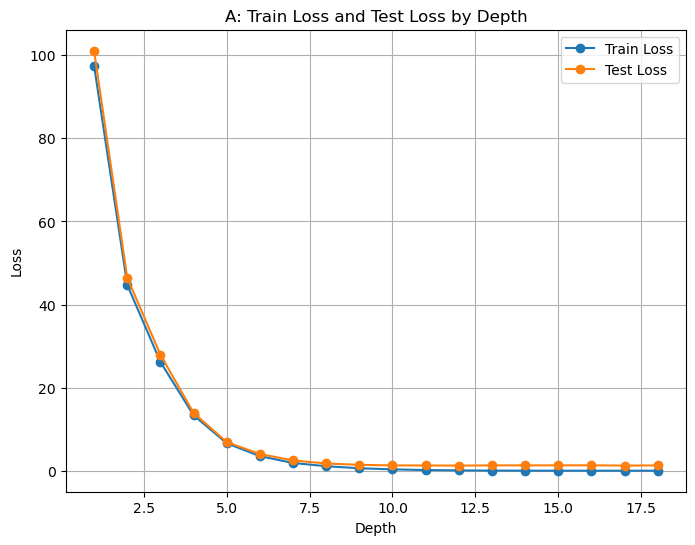

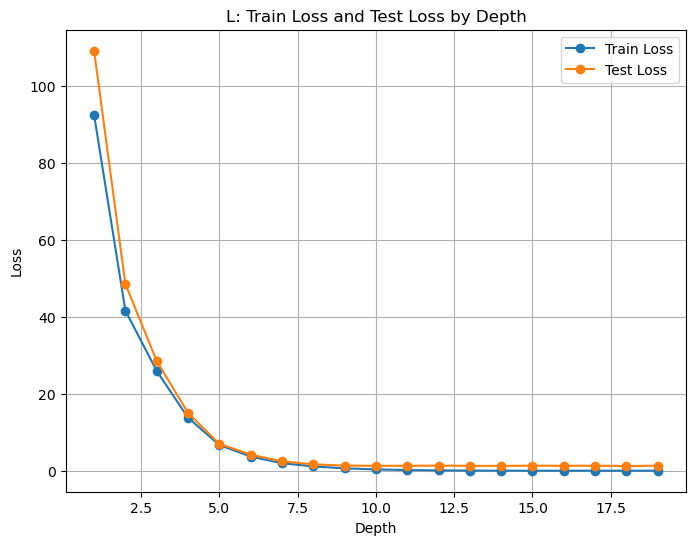

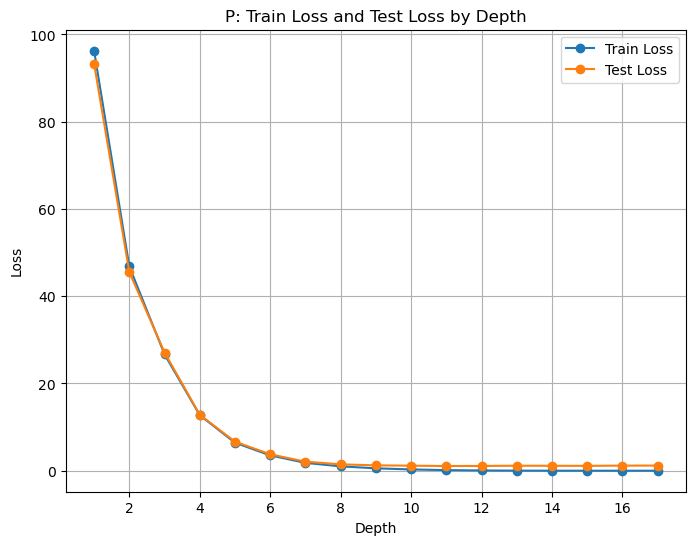

In [7]:
def plot_train_test_loss(depth_records, title):
    depths = [record.depth for record in depth_records]
    train_errors = [record.train_loss for record in depth_records]
    test_errors = [record.test_loss for record in depth_records]

    plt.figure(figsize=(8, 6))
    plt.plot(depths, train_errors, marker='o', label='Train Loss')
    plt.plot(depths, test_errors, marker='o', label='Test Loss')
    plt.title(f'{title}: Train Loss and Test Loss by Depth')
    plt.xlabel('Depth')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_train_test_loss(depth_records_A, 'A')
plot_train_test_loss(depth_records_L, 'L')
plot_train_test_loss(depth_records_P, 'P')

### LightGBM回帰検証

In [8]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def lightgbm_regression(X_train, X_test, y_train, y_test, num_leaves=31, learning_rate=0.05, n_estimators=100, random_state=0):
    # LightGBM回帰器の作成
    model = lgb.LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state, verbose=-1)
    # モデルの訓練
    model.fit(X_train, y_train)
    # 検証データでの予測
    y_test_pred = model.predict(X_test)
    # 検証データの平均二乗誤差を計算
    test_mse = mean_squared_error(y_test, y_test_pred)
    return test_mse

# パラメータ設定
num_leaves = 100
learning_rate = 0.3
n_estimators = 100
random_state = 0

# Aのデータに対するLightGBMモデルの平均二乗誤差
test_mse_A_lgb = lightgbm_regression(AX_train, AX_test, Ay_train, Ay_test, num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state)
print(f"Aの検証用データの平均二乗誤差（LightGBM）: {test_mse_A_lgb}")
# Lのデータに対するLightGBMモデルの平均二乗誤差
test_mse_L_lgb = lightgbm_regression(LX_train, LX_test, Ly_train, Ly_test, num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state)
print(f"Lの検証用データの平均二乗誤差（LightGBM）: {test_mse_L_lgb}")
# Pのデータに対するLightGBMモデルの平均二乗誤差
test_mse_P_lgb = lightgbm_regression(PX_train, PX_test, Py_train, Py_test, num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state)
print(f"Pの検証用データの平均二乗誤差（LightGBM）: {test_mse_P_lgb}")
# ALP平均
test_mse_mean_lgb = (test_mse_A_lgb + test_mse_L_lgb + test_mse_P_lgb) / 3
print(f"\nALPの平均平均二乗誤差（LightGBM）: {test_mse_mean_lgb}")
# 結果を格納
modelMseDict["LightGBM回帰モデル"] = test_mse_mean_lgb

Aの検証用データの平均二乗誤差（LightGBM）: 0.4948848760918836
Lの検証用データの平均二乗誤差（LightGBM）: 0.38505662155920006
Pの検証用データの平均二乗誤差（LightGBM）: 0.46993962687254986

ALPの平均平均二乗誤差（LightGBM）: 0.44996037484121115


In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

def lightgbm_regression_grid_search(params, X_train, X_test, y_train, y_test, random_state=0):
    # LightGBM回帰器の作成
    model = lgb.LGBMRegressor(n_estimators=100, random_state=random_state, verbose=-1)
    # グリッドサーチの実施
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=5)
    grid_cv.fit(X_train, y_train)
    # 検証データでの予測
    y_test_pred = grid_cv.predict(X_test)
    # 検証データの平均二乗誤差を算出
    test_mse = mean_squared_error(y_test, y_test_pred)
    # 最適なパラメータとスコアを表示
    print("Best parameters:", grid_cv.best_params_)
    # print("Best score:", grid_cv.best_score_)
    best_score = grid_cv.best_score_

    # 最適なパラメータを辞書に格納
    best_params = grid_cv.best_params_
    best_params_dict = {f'best_{param}': best_params[param] for param in best_params}

    return best_params_dict, test_mse, best_score

# パラメータ設定
params = {
    'metric': ['rmse', 'mae', 'quantile', 'huber'],
    'num_leaves': [3, 5, 10, 20, 30, 50, 100, 150, 200],
    'learning_rate': [0.05, 0.075, 0.1, 0.15, 0.2],
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_freq': [3, 5, 7, 9, 11],
    'alpha': [0.05, 0.1, 0.2, 0.5, 0.95],
}
random_state = 0

# Aのデータに対するLightGBMモデルのグリッドサーチと結果の取得
best_params_A, test_mse_A, best_score_A = lightgbm_regression_grid_search(params, AX_train, AX_test, Ay_train, Ay_test, random_state=random_state)
# Lのデータに対するLightGBMモデルのグリッドサーチと結果の取得
best_params_L, test_mse_L, best_score_L = lightgbm_regression_grid_search(params, LX_train, LX_test, Ly_train, Ly_test, random_state=random_state)
# Pのデータに対するLightGBMモデルのグリッドサーチと結果の取得
best_params_P, test_mse_P, best_score_P = lightgbm_regression_grid_search(params, PX_train, PX_test, Py_train, Py_test, random_state=random_state)
print(f"Aの最適なパラメータと平均二乗誤差: {test_mse_A}")
print(f"Lの最適なパラメータと平均二乗誤差: {test_mse_L}")
print(f"Pの最適なパラメータと平均二乗誤差: {test_mse_P}")
# ALP平均
test_mse_mean_lgb = (test_mse_A_lgb + test_mse_L_lgb + test_mse_P_lgb) / 3
print(f"\nALPの平均平均二乗誤差（LightGBM）: {test_mse_mean_lgb}")
# ALP平均
best_score_mean_lgb = (best_score_A + best_score_L + best_score_P) / 3
print(f"\nベストスコア（LightGBM）: {best_score_mean_lgb}")
# 結果を格納
modelMseDict["LightGBM回帰モデル with GS"] = test_mse_mean_lgb

In [ ]:
# 平均平均二乗誤差の低い順にソート＆データフレームに格納
sorted_models = sorted(modelMseDict.items(), key=lambda x: x[1])
# ソートされたデータをデータフレームに格納
mse_df = pd.DataFrame(sorted_models, columns=["モデル名", "平均平均二乗誤差"])
# データフレームを出力
print("各モデルの平均平均二乗誤差（低い順）:")
print(mse_df)

各モデルの平均平均二乗誤差（低い順）:
                モデル名    平均平均二乗誤差
0      LightGBM回帰モデル    0.424321
1     ランダムフォレスト回帰モデル    0.457775
2       XGBoost回帰モデル    0.510714
3           単純回帰木モデル    1.095166
4   サポートベクターマシン回帰モデル   14.160577
5        ベイズリッジ回帰モデル   19.364049
6             重回帰モデル   19.364406
7           リッジ回帰モデル   19.364406
8       カーネルリッジ回帰モデル   20.716747
9          K最近傍回帰モデル   27.777967
10          ラッソ回帰モデル   59.119082
11     エラスティックネットモデル  132.349605


## 学習モデルの作成

### LightGBM回帰作成

In [ ]:
import pickle
import lightgbm as lgb

# LightGBM回帰モデル
def train_and_save_lgb_model(X, y, best_params, model_path):
    model = lgb.LGBMRegressor(**best_params, random_state=0, n_estimators=100)
    model.fit(X, y)
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

# モデルを保存
train_and_save_lgb_model(AX, Ay, best_params_A, './LightGBM/Amodel.pkl')
train_and_save_lgb_model(LX, Ly, best_params_L, './LightGBM/Lmodel.pkl')
train_and_save_lgb_model(PX, Py, best_params_P, './LightGBM/Pmodel.pkl')


# 目標回数の推論